# Atmospheric Rivers: run detection pipeline and QC outputs

This notebook will import the master processing function from the `ar_detection.py` module and run the entire processing workflow with minimal input. Before executing this notebook be sure you've set your `AR_DATA_DIR` environment variable, and have executed both the `download.py` and `compute_ivt.py` scripts.

In [1]:
from ar_detection import detect_all_ars
from config import ard_fp, shp_fp, csv_fp, ak_shp, landfall_6hr_fp, landfall_events_fp

In [2]:
detect_all_ars(ard_fp, 5, shp_fp, csv_fp, ak_shp, landfall_6hr_fp, landfall_events_fp)

Getting axis length (km) for each AR target:: 100%|██████████| 43832/43832 [09:33<00:00, 76.40it/s] 
Getting overall orientation (azimuth) for each AR target:: 100%|██████████| 43832/43832 [07:36<00:00, 96.09it/s] 
Getting mean poleward strength for each AR target:: 100%|██████████| 43832/43832 [01:04<00:00, 677.62it/s]
Getting directional coherence for each AR target:: 100%|██████████| 43832/43832 [02:43<00:00, 268.21it/s]
Getting total IVT strength for each AR target:: 100%|██████████| 43832/43832 [00:22<00:00, 1967.12it/s]
Getting relative IVT strength for each AR target:: 100%|██████████| 43832/43832 [00:21<00:00, 2052.37it/s]
100%|██████████| 21234/21234 [08:50<00:00, 40.04it/s] 


In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import random

In [4]:
#import shps to gdfs
raw = gpd.read_file(landfall_6hr_fp)
events = gpd.read_file(landfall_events_fp)

#import ak shp
ak = gpd.read_file(ak_shp)
# reproject AK coastline to match AR CRS, and dissolve into one multipolygon
ak_ = ak.to_crs(raw.crs)
ak_d = ak_.dissolve()

In [5]:
#count number of landfalling ARs at individual 6hr timesteps
len(raw)

10399

In [6]:
#check AR attributes:
#all properties and criteria are preserved
#AR IDs (index) are unique integers, could also be labeled using year / month / etc

raw.head()

,index,time,label,ratio,length,orient,poleward,dir_coher,mean_dir,tot_str,rel_str,crit1,crit2,crit3,crit4,crit5,crit_cnt,geometry
0,3,1992-01-01 06:00:00,2.0,3.5,4854,33,221,87,358,2230418,488,1,1,1,1,1,5,"POLYGON ((-149.62500 61.12500, -149.37500 61.1..."
1,4,1992-01-01 12:00:00,4.0,4.2,3773,35,224,85,0,2233790,443,1,1,1,1,1,5,"POLYGON ((-143.12500 60.62500, -142.62500 60.6..."
2,21,1992-01-08 00:00:00,2.0,3.8,5254,25,232,81,360,3547765,569,1,1,1,1,1,5,"POLYGON ((-145.62500 60.62500, -145.12500 60.6..."
3,22,1992-01-08 06:00:00,2.0,3.7,4862,28,229,83,1,3182008,575,1,1,1,1,1,5,"POLYGON ((-135.87500 58.62500, -134.62500 58.6..."
4,24,1992-01-08 18:00:00,1.0,2.3,4606,22,249,77,1,3141921,530,1,1,1,1,1,5,"POLYGON ((-146.37500 60.62500, -142.37500 60.6..."


(25.0, 72.0)

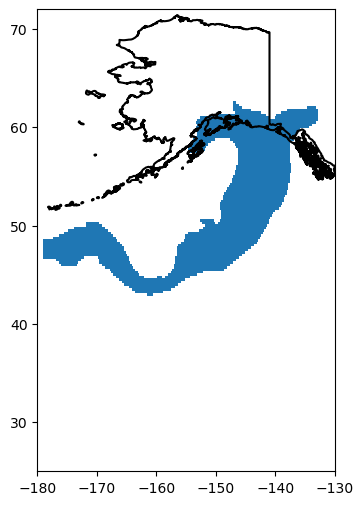

In [7]:
#plot a random datetime from the raw Alaska ARs
#these shapes represent landfalling ARs at individual 6hr timesteps...
#run this cell multiple times to get an idea of what some of these look like

random_date = random.choice(list(raw.index))
fig, ax = plt.subplots(figsize=(6,6))
#plt.suptitle)

ak_d.boundary.plot(ax=ax, color='black')
raw[raw.index==random_date].plot(ax=ax)

plt.xlim([-180, -130])
plt.ylim([25, 72])

In [8]:
#count number of landfalling AR events when grouped by adjacent dates
len(events)

1670

In [9]:
#average landfalling AR events per year ...  is this even reasonable?
len(events)/30

55.666666666666664

In [10]:
#check attributes:
#event IDs are unique integers, could also be labeled using year / month / etc
#start and end columns can be parsed as datetime objects to get approximate duration
#multipolygons can be dissolved into single polygon representing entire AR impact area
#properties are disregarded during the grouping operation - could these values be aggregated somehow?

events.head()

,event_id,start,end,geometry
0,0,1992-01-01 06:00:00,1992-01-01 12:00:00,"MULTIPOLYGON (((-149.62500 61.12500, -149.3750..."
1,1,1992-01-08 00:00:00,1992-01-19 00:00:00,"MULTIPOLYGON (((-145.62500 60.62500, -145.1250..."
2,2,1992-01-21 12:00:00,1992-01-21 12:00:00,"POLYGON ((-167.12500 53.87500, -165.12500 53.8..."
3,3,1992-01-25 06:00:00,1992-01-26 12:00:00,"MULTIPOLYGON (((-156.12500 57.37500, -155.1250..."
4,4,1992-01-29 18:00:00,1992-01-30 12:00:00,"MULTIPOLYGON (((-140.12500 56.62500, -137.8750..."


(25.0, 72.0)

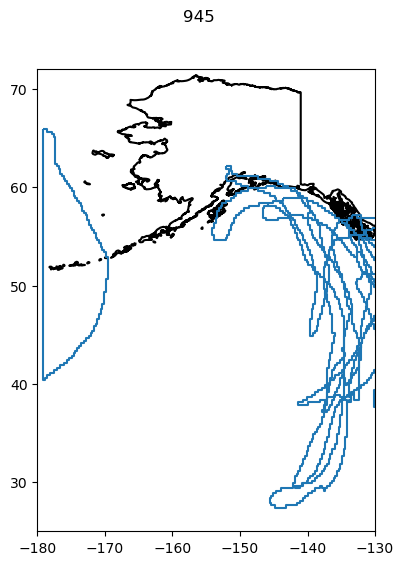

In [11]:
#plot a random event from the combined Alaska ARs
#these shapes represent landfalling ARs at grouped by adjacent dates
#the overlapping multipolygons show the varying extent of the AR event and give a general "area of impact"
#run this cell multiple times to get an idea of what some of these look like

random_event = random.choice(list(events.index.values))
fig, ax = plt.subplots(figsize=(6,6))
plt.suptitle(random_event)

ak_d.boundary.plot(ax=ax, color='black')
events[events.index==random_event].boundary.plot(ax=ax)

plt.xlim([-180, -130])
plt.ylim([25, 72])